# **Fruits Classification using CNN in IBM Cloud**

## **Number of classes** - 42
## **Number of distinct fruits classes** - 11
## **Number of distinct vegetables classes** - 12



## **Setting up things in IBM Cloud**

In [3]:
!pip install keras
!pip install tensorflow

In [ ]:
import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id="eeJ1bmJC6Fg-69GLhQ-BVukvrdm7iQ7eJBqOJ12g_U8D",
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.private.us.cloud-object-storage.appdomain.cloud')

bucket = 'main-donotdelete-pr-zrukxx0pomjjg2'
object_key = 'dataset.zip'

streaming_body_2 = cos_client.get_object(Bucket=bucket, Key=object_key)['Body']

# Your data file was loaded into a botocore.response.StreamingBody object.
# Please read the documentation of ibm_boto3 and pandas to learn more about the possibilities to load the data.
# ibm_boto3 documentation: https://ibm.github.io/ibm-cos-sdk-python/
# pandas documentation: http://pandas.pydata.org/


In [1]:
pwd

'/home/wsuser/work'

In [6]:

import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='1BMbTMmQ189qWmjIquCeQTiUNxMGb8WIH67SNl4c2W5b',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.private.us.cloud-object-storage.appdomain.cloud')

bucket = 'main-donotdelete-pr-zrukxx0pomjjg2'
object_key = 'dataset.zip'

streaming_body_3 = cos_client.get_object(Bucket=bucket, Key=object_key)['Body']

# Your data file was loaded into a botocore.response.StreamingBody object.
# Please read the documentation of ibm_boto3 and pandas to learn more about the possibilities to load the data.
# ibm_boto3 documentation: https://ibm.github.io/ibm-cos-sdk-python/
# pandas documentation: http://pandas.pydata.org/


In [7]:
from io import BytesIO
import zipfile
unzip = zipfile.ZipFile(BytesIO(streaming_body_3.read()), 'r')
file_paths = unzip.namelist()
for path in file_paths:
    unzip.extract(path)

In [12]:
import os
filenames = os.listdir('/home/wsuser/work/dataset/')

## **Image Augementation**

In [13]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

num_classes = 42
img_rows, img_cols = 32, 32
batch_size = 16

train_data_dir = r'/home/wsuser/work/dataset/Training'
validation_data_dir = r'/home/wsuser/work/dataset/Test'

# Let's use some data augmentaiton 
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=30,
      width_shift_range=0.3,
      height_shift_range=0.3,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows, img_cols),
        batch_size =batch_size,
        class_mode='categorical',
        shuffle=True)
 
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 21091 images belonging to 42 classes.
Found 7059 images belonging to 42 classes.


## **Creating CNN model**

In [14]:
model = Sequential()

# Padding = 'same'  results in padding the input such that
# the output has the same length as the original input
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape= (img_rows, img_cols, 3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer and configure some parameters
#opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 32)        0         
                                                        

## **Model Training**

In [16]:
from tensorflow.keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

                     
checkpoint = ModelCheckpoint(r"/home/wsuser/work/nutrition.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0001)

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint, reduce_lr]

# We use a very small learning rate 
model.compile(loss = 'categorical_crossentropy',
              optimizer = RMSprop(lr = 0.001),
              metrics = ['accuracy'])

nb_train_samples = 21091
nb_validation_samples = 7059
epochs = 10

history = model.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)

/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)
/tmp/wsuser/ipykernel_164/1615154690.py:35: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/10
1318/1318 [==============================] - ETA: 0s - loss: 1.5080 - accuracy: 0.5159
Epoch 00001: val_loss improved from inf to 0.98967, saving model to /home/wsuser/work/nutrition.h5
1318/1318 [==============================] - 169s 127ms/step - loss: 1.5080 - accuracy: 0.5159 - val_loss: 0.9897 - val_accuracy: 0.7419 - lr: 0.0010
Epoch 2/10
1318/1318 [==============================] - ETA: 0s - loss: 0.4640 - accuracy: 0.8464
Epoch 00002: val_loss improved from 0.98967 to 0.96504, saving model to /home/wsuser/work/nutrition.h5
1318/1318 [==============================] - 165s 125ms/step - loss: 0.4640 - accuracy: 0.8464 - val_loss: 0.9650 - val_accuracy: 0.8196 - lr: 0.0010
Epoch 3/10
1318/1318 [==============================] - ETA: 0s - loss: 0.3117 - accuracy: 0.9080
Epoch 00003: val_loss improved from 0.96504 to 0.66326, saving model to /home/wsuser/work/nutrition.h5
1318/1318 [==============================] - 165s 126ms/step - loss: 0.3117 - accuracy: 0.9080 - val_

In [17]:
!tar -zcvf nutrition.tgz nutrition.h5

nutrition.h5


In [50]:
ls -1

body_cloud.tar.gz
dataset/
nutrition.h5
nutrition.tgz


In [19]:
!pip install watson-machine-learning-client --upgrade

In [20]:
from ibm_watson_machine_learning import APIClient
wml_credentials = {"url":"https://us-south.ml.cloud.ibm.com", "apikey":"eeJ1bmJC6Fg-69GLhQ-BVukvrdm7iQ7eJBqOJ12g_U8D"}

In [21]:
client = APIClient(wml_credentials)

In [22]:
def guid_from_space_name(client,space_name):
    space = client.spaces.get_details()
    return(next(item for item in space['resources'] if item['entity']["name"]==space_name)['metadata']['id'])

In [23]:
space_uid = guid_from_space_name(client,'fruitsclassification' )
print(space_uid)

d7509c4b-aa09-4b61-9e79-78dca9c5d810


In [24]:
client.set.default_space(space_uid)

'SUCCESS'

In [25]:
software_spec_uid = client.software_specifications.get_uid_by_name("tensorflow_rt22.1-py3.9")

In [26]:
print(software_spec_uid)

acd9c798-6974-5d2f-a657-ce06e986df4d


In [27]:
client.software_specifications.list()

-----------------------------  ------------------------------------  ----
NAME                           ASSET_ID                              TYPE
default_py3.6                  0062b8c9-8b7d-44a0-a9b9-46c416adcbd9  base
kernel-spark3.2-scala2.12      020d69ce-7ac1-5e68-ac1a-31189867356a  base
pytorch-onnx_1.3-py3.7-edt     069ea134-3346-5748-b513-49120e15d288  base
scikit-learn_0.20-py3.6        09c5a1d0-9c1e-4473-a344-eb7b665ff687  base
spark-mllib_3.0-scala_2.12     09f4cff0-90a7-5899-b9ed-1ef348aebdee  base
pytorch-onnx_rt22.1-py3.9      0b848dd4-e681-5599-be41-b5f6fccc6471  base
ai-function_0.1-py3.6          0cdb0f1e-5376-4f4d-92dd-da3b69aa9bda  base
shiny-r3.6                     0e6e79df-875e-4f24-8ae9-62dcc2148306  base
tensorflow_2.4-py3.7-horovod   1092590a-307d-563d-9b62-4eb7d64b3f22  base
pytorch_1.1-py3.6              10ac12d6-6b30-4ccd-8392-3e922c096a92  base
tensorflow_1.15-py3.6-ddl      111e41b3-de2d-5422-a4d6-bf776828c4b7  base
autoai-kb_rt22.2-py3.10        125b6d9

In [29]:
software_spec_uid = client.software_specifications.get_uid_by_name("tensorflow_rt22.1-py3.9")
print(software_spec_uid)

acd9c798-6974-5d2f-a657-ce06e986df4d


In [39]:
model_details = client.repository.store_model(model = 'nutrition.tgz' , meta_props = {
    client.repository.ModelMetaNames.NAME : "CNN", 
    client.repository.ModelMetaNames.TYPE : "tensorflow_rt22.1",
    client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: software_spec_uid
})
model_id = client.repository.get_model_id(model_details)

In [40]:
streaming_body_4 = cos_client.get_object(Bucket=bucket, Key=object_key)['Body']

# Your data file was loaded into a botocore.response.StreamingBody object.
# Please read the documentation of ibm_boto3 and pandas to learn more about the possibilities to load the data.
# ibm_boto3 documentation: https://ibm.github.io/ibm-cos-sdk-python/
# pandas documentation: http://pandas.pydata.org/


In [51]:

import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='1BMbTMmQ189qWmjIquCeQTiUNxMGb8WIH67SNl4c2W5b',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.private.us.cloud-object-storage.appdomain.cloud')

bucket = 'main-donotdelete-pr-zrukxx0pomjjg2'
object_key = '38BeFeatureLemonC_621050532.jpg'

streaming_body_5 = cos_client.get_object(Bucket=bucket, Key=object_key)['Body']

# Your data file was loaded into a botocore.response.StreamingBody object.
# Please read the documentation of ibm_boto3 and pandas to learn more about the possibilities to load the data.
# ibm_boto3 documentation: https://ibm.github.io/ibm-cos-sdk-python/
# pandas documentation: http://pandas.pydata.org/


## **Loading Model**

In [59]:
from keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img
model = load_model(r"/home/wsuser/work/nutrition.h5")
import numpy as np
from tensorflow.keras.utils import img_to_array

In [64]:

import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='eeJ1bmJC6Fg-69GLhQ-BVukvrdm7iQ7eJBqOJ12g_U8D',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.private.us.cloud-object-storage.appdomain.cloud')

bucket = 'main-donotdelete-pr-zrukxx0pomjjg2'
object_key = 'lemon.jpg'

streaming_body_6 = cos_client.get_object(Bucket=bucket, Key=object_key)['Body']

# Your data file was loaded into a botocore.response.StreamingBody object.
# Please read the documentation of ibm_boto3 and pandas to learn more about the possibilities to load the data.
# ibm_boto3 documentation: https://ibm.github.io/ibm-cos-sdk-python/
# pandas documentation: http://pandas.pydata.org/


In [65]:
import pandas as pd
img = load_img(streaming_body_6, grayscale = False, target_size = (32,32))
x = img_to_array(img)
x = np.expand_dims (x,axis = 0)
predictions = (model.predict(x) > 0.5).astype("int32")
print(predictions)

TypeError: expected str, bytes or os.PathLike object, not StreamingBody

## **Model Prediction**

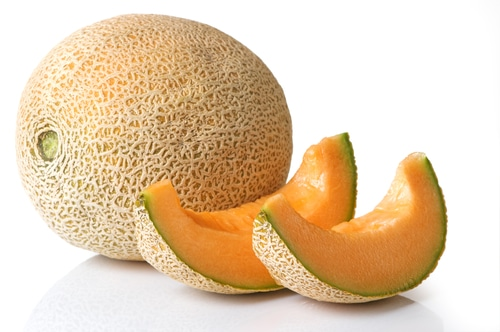

Predicting this fruit (which is Cantaloupe) using CNN model file (nutrition.h5)

In [32]:
index = predictions[0].nonzero()[0][0]


In [47]:
from scripts.File_Extractor import index_to_information
predicted_class_info = index_to_information(index,[r"/content/csv/index_list.csv",r"/content/csv/nutrients_list.csv",r"/content/csv/price_list.csv"] )

Cantaloupe


In [48]:
predicted_class_info

{'NAME': 'Cantaloupe',
 'SERVING': '100g',
 'CALORIES': '34',
 'FIBER': '0.9g',
 'FAT': '0.2g',
 'PROTEIN': '0.8g',
 'WATER': '89%',
 'SUGAR ': '8g',
 'CARBOHYDRATES': '8g',
 'FOOD TYPE': 'fruit',
 'WHOLESALE PRICE': '28',
 'RETAIL PRICE': '[32, 36]',
 'SHOPPING MALL PRICE': '[34, 46]',
 'QUANTITY': '1kg',
 'TYPE': 'fruits'}